<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/05_transfert_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: image classification with transfert learning**

| | |
|------|------|
| Filename | 05_transfert_learning.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | December 19, 2024 |
| Aim(s) | Classify images of flowers with a pre-trained network |
| Dataset(s) | Flower API Google database [[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)|
| Version | Python 3.12 - TensorFlow 2.17.0 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. GPU execution is recommanded.
3. Run all and read comments.

---

#### **Motivation**

The flower Google API database is again used for this model, which uses a pre-trained model (MobileNet V2). The aim is to use this complex model to extract complex features from flower images. This is called transfer learning.

---

#### **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'

---


#### **1. Python librairies & display utilities [RUN ME]**

In [2]:
from numpy import array, argmax, max                         # scientific computing
from os import path, listdir                                 # miscellaneous operating system interfaces
from PIL import Image                                        # image processing capabilities
from tensorflow import keras, data, expand_dims, nn, concat  # machine learning models
from keras import layers, utils, Sequential, Input, losses
import matplotlib.pyplot as plt                              # graphing package

In [3]:
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  training_curves_1 = Image.open("TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/training_curves_1.jpeg") # see section 2.4
  training_curves_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/training_curves_2.jpeg") # see section 2.4
  model = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/05_transfert_learning.keras')
  model_fine_tune = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/05_transfert_learning_FT.keras')
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return training_curves_1, training_curves_2, model, model_fine_tune

In [32]:
def get_github_photo():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  tulip = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/tulip.jpeg") # see section 3
  rose = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/rose.jpeg") # see section 3
  daisy = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/daisy.jpeg") # see section 3
  sunflowers = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/sunflowers.jpeg") # see section 3
  bouquet = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet.jpeg") # see section 3
  bouquet_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet_2.jpeg") # see section 3
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return tulip, rose, daisy, sunflowers, bouquet, bouquet_2

In [5]:
def plot_images(image, *label):
  plt.imshow(image)
  plt.title("%s" %label)
  image = plt.axis("off")
  return image

In [6]:
# plot training curves

def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  fig = plt.subplot(2,1,1)
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6), plt.ylabel('Loss', fontsize=12)

  plt.subplot(2,1,2)
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.xlabel('Epochs', fontsize=12), plt.ylabel('Accuracy', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)

---


#### **2. Retrieve data and data augmentation**

###### **2.1. Data acquisition**

In [7]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = utils.get_file('flower_photos', dataset_url, untar=True)
data_dir = path.join(path.dirname(data_dir), 'flower_photos')

In [8]:
batch_size = 32
img_height, img_width = 160, 160
AUTOTUNE = data.AUTOTUNE

train_dataset = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
validation_dataset = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

class_names = train_dataset.class_names

val_ds_batch = data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_ds_batch // 5) # create a test set from 20% of the validation set
validation_dataset = validation_dataset.skip(val_ds_batch // 5)
print("# of training batches: %d" %data.experimental.cardinality(train_dataset), "\n# of test batches: %d" %data.experimental.cardinality(test_dataset), "\n# of validation batches: %d" %data.experimental.cardinality(validation_dataset))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
# of training batches: 92 
# of test batches: 4 
# of validation batches: 19


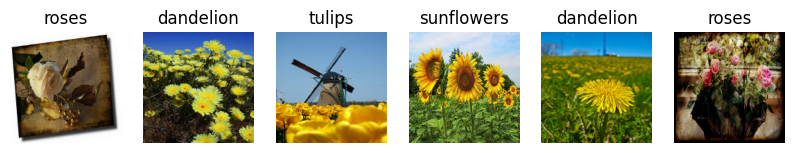

In [9]:
plt.figure(figsize=(10, 8))
for images, labels in train_dataset.take(1):
  tensor_images, tensor_labels = images, labels
  for i in range(6):
    ax = plt.subplot(1, 6, i + 1)
    plot_images(images[i].numpy().astype("uint8"), class_names[labels[i]])

###### **2.2. Data augmentation**

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),], name="data_augmentation_layer")

images_modified = data_augmentation(tensor_images) # apply to the example set

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


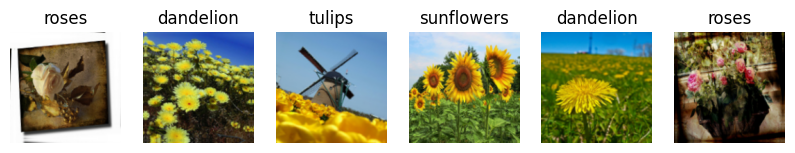

In [11]:
plt.figure(figsize=(10, 8))
for i in range(6):
  ax = plt.subplot(1, 6, i + 1)
  plot_images(images_modified[i].numpy().astype("uint8"), class_names[labels[i]])

---


#### **3. MobileNet base model**

###### **3.1. Base model from the pre-trained model MobileNet V2**

In [12]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [13]:
img_size = (img_height, img_width)
img_shape = img_size + (3,) # add rgb code
base_model = keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

In [14]:
base_model.trainable = False

In [15]:
def create_model():
  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(5)(x)
  model = keras.Model(inputs, outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

  return model

In [16]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, **kwargs)

  return log.history["loss"], log.history["sparse_categorical_accuracy"], log.history["val_loss"], log.history["val_sparse_categorical_accuracy"]

In [17]:
base_learning_rate = 0.0001
model = create_model()
epochs = 10

if training_phase == "Yes":
  classifier_accuracy = train_model(model, train_dataset, validation_dataset, epochs=epochs)
  model.save('05_transfert_learning.keras')
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), argmax(classifier_accuracy[3])+1))

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 375 (delta 147), reused 88 (delta 88), pack-reused 194 (from 2)
Receiving objects: 100% (375/375), 60.62 MiB | 18.85 MiB/s, done.
Resolving deltas: 100% (187/187), done.


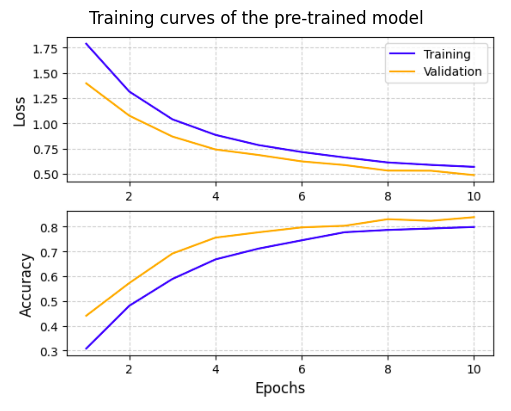

In [18]:
if training_phase == 'Yes':
  plot_evolution(classifier_accuracy)
else:
  training_curves_1, training_curves_2, model, model_FT = get_github_files()
  plt.imshow(training_curves_1), plt.title("Training curves of the pre-trained model"), plt.axis("off")

In [19]:
loss_test, accuracy_test = model.evaluate(test_dataset, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.5 and test accuracy value 82.8 %


---


#### **4. Fine tuning**

In [20]:
base_model.trainable = True

In [21]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]: # Freeze all the layers before the `fine_tune_at` layer
  layer.trainable = False

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [23]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

if training_phase == "Yes":
  classifier_accuracy_FT = train_model(model, train_dataset, validation_dataset, epochs=fine_tune_epochs)
  model.save('05_transfert_learning_FT.keras')
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy_FT[3]), argmax(classifier_accuracy_FT[3])+1))

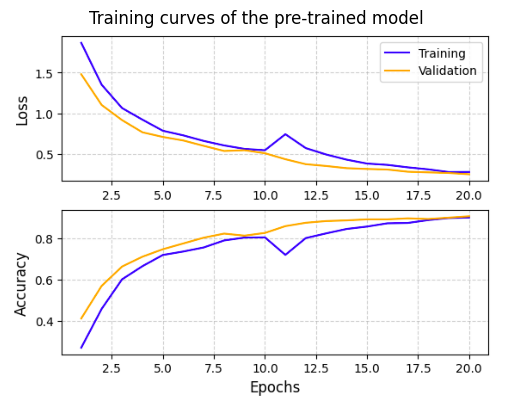

In [24]:
if training_phase == 'Yes':
  plot_evolution(concat([classifier_accuracy, classifier_accuracy_FT], 1))
else:
  model = model_FT
  plt.imshow(training_curves_2), plt.title("Training curves of the pre-trained model"), plt.axis("off")

In [25]:
loss_test, accuracy_test = model.evaluate(test_dataset, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.3 and test accuracy value 88.3 %


---


#### **5. Predictions**

In [33]:
tulip, rose, daisy, sunflowers, bouquet, bouquet_2 = get_github_photo()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 380 (delta 149), reused 88 (delta 88), pack-reused 194 (from 2)
Receiving objects: 100% (380/380), 60.83 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (189/189), done.


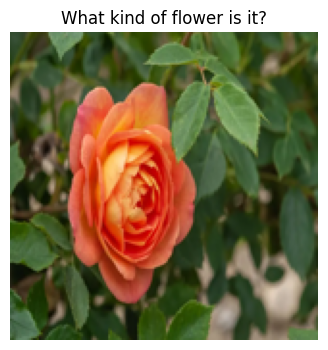

In [37]:
img = rose
img = Image.fromarray(array(img))
resized_img = img.resize((img_height, img_width))
plt.figure(figsize=(4, 4))
plt.imshow(resized_img), plt.title("What kind of flower is it?"), plt.axis("off")
plt.show()

In [38]:
resized_img_array = expand_dims(array(resized_img), 0)
predictions = model.predict(resized_img_array)
score = nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence." .format(class_names[argmax(score)], 100 * max(score)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
This image most likely belongs to roses with a 99.77 percent confidence.
